<a href="https://colab.research.google.com/github/eric-zheng-0912/eric-zheng-0912/blob/main/%E4%BA%A4%E6%98%93%E7%A8%8B%E5%BC%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

正在掛載 Google Drive...
Mounted at /content/drive

嘗試讀取股價資料: /content/drive/MyDrive/金融程式交易/stockprice.csv
嘗試讀取財報資料 (融資融券): /content/drive/MyDrive/金融程式交易/程式設計02.csv
資料讀取成功。

--- 步驟 1: 資料前處理與特徵工程 (日資料轉季資料) ---
資料整合與特徵工程完成。最終資料集大小: (33282, 11)

--- 步驟 2 & 3: 開始執行分季回測流程 (市值篩選 + XGBoost) ---


--- 步驟 4: 回測結果分析與診斷報告 ---
1. 季度資料涵蓋範圍: 2016-12-31 至 2025-12-31
2. 總季度數 (T): 37 季
3. 模型訓練所需季度數 (T_train): 16 季
4. 預計回測起始季度索引: 16

==== 每季投組績效 (完整列表) ==== 來源 DataFrame: [df_output]
    Year  Quarter  n_universe  n_300  n_200  n_50 portfolio_ret
0   2020        4         892    300    300    50      0.108711
1   2021        1         895    300    300    50      0.285337
2   2021        2         897    300    300    50     -0.079792
3   2021        3         901    300    300    50      0.129386
4   2021        4         908    300    300    50     -0.008881
5   2022        1         911    300    300    50     -0.182287
6   2022        2         913    300    300    50     -0.042646
7   2022        3     

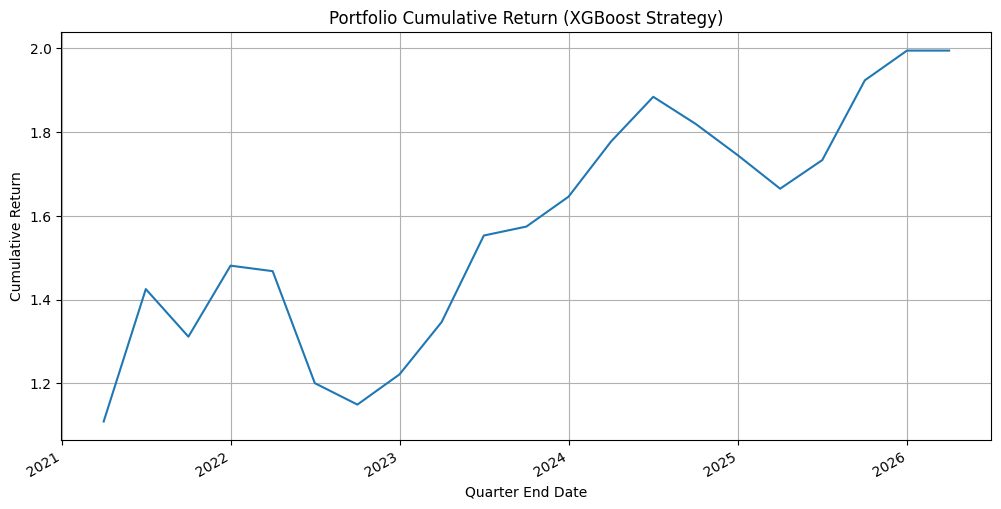


--- 程式執行完畢 ---


In [6]:
# ==============================================================================
# 步驟 0: 環境設置與資料讀取
# ==============================================================================
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import os
import matplotlib.pyplot as plt

# 1. 掛載 Google Drive
print("正在掛載 Google Drive...")
try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"掛載 Google Drive 失敗: {e}")

# 2. 設定檔案路徑
base_path = '/content/drive/MyDrive/金融程式交易/'
stockprice_path = os.path.join(base_path, 'stockprice.csv')
fundamental_path = os.path.join(base_path, '程式設計02.csv')

# 3. 讀取資料 (使用 'cp950' 編碼和錯誤處理)
df_price = None
df_fund = None

try:
    print(f"\n嘗試讀取股價資料: {stockprice_path}")
    # 讀取股價資料
    try:
        df_price = pd.read_csv(stockprice_path, encoding='cp950')
    except UnicodeDecodeError:
        print("  > cp950 解碼股價資料失敗，嘗試使用 utf-8 忽略錯誤字元。")
        df_price = pd.read_csv(stockprice_path, encoding='utf-8', errors='ignore')

    print(f"嘗試讀取財報資料 (融資融券): {fundamental_path}")
    # 讀取財報資料
    try:
        df_fund = pd.read_csv(fundamental_path, encoding='cp950')
    except UnicodeDecodeError:
        print("  > cp950 解碼財報資料失敗，嘗試使用 utf-8 忽略錯誤字元。")
        df_fund = pd.read_csv(fundamental_path, encoding='utf-8', errors='ignore')

    print("資料讀取成功。")

    # --- 欄位名稱映射與標準化 (根據您的數據確認) ---

    # 股價資料處理：將中文欄位名稱映射為標準英文名稱
    df_price.rename(columns={
        '年月日': 'Date',
        '證券代碼': 'Stock_ID',
        '收盤價(元)': 'Close',
        '成交量(千股)': 'Volume',
        '市值(百萬元)': 'MarketCap',
    }, inplace=True)

    required_price_cols = ['Date', 'Stock_ID', 'Close', 'Volume', 'MarketCap']
    if not all(col in df_price.columns for col in required_price_cols):
        missing = [col for col in required_price_cols if col not in df_price.columns]
        raise KeyError(f"股價資料缺少必要的欄位：{missing}。請檢查 CSV 檔案和欄位映射。")

    # *** 關鍵修正點：強制日期格式為 %Y%m%d ***
    df_price['Date'] = pd.to_datetime(df_price['Date'].astype(str), format='%Y%m%d', errors='coerce')
    df_price.dropna(subset=['Date'], inplace=True) # 移除無法解析的日期
    df_price['Stock_ID'] = df_price['Stock_ID'].astype(str)

    # 財報資料處理：將融資融券資料的中文欄位名稱映射為標準英文名稱
    df_fund.rename(columns={
        '年月日': 'Quarter_End_Date',
        '證券代碼': 'Stock_ID',
    }, inplace=True)

    required_fund_cols = ['Quarter_End_Date', 'Stock_ID', '融資餘額(張)', '融資(買+賣)/成交量 %']
    if not all(col in df_fund.columns for col in required_fund_cols):
        missing = [col for col in required_fund_cols if col not in df_fund.columns]
        raise KeyError(f"融資資料缺少必要的欄位：{missing}。請檢查 CSV 檔案和欄位映射。")

    # *** 關鍵修正點：強制日期格式為 %Y%m%d ***
    df_fund['Quarter_End_Date'] = pd.to_datetime(df_fund['Quarter_End_Date'].astype(str), format='%Y%m%d', errors='coerce')
    df_fund.dropna(subset=['Quarter_End_Date'], inplace=True) # 移除無法解析的日期

    df_fund['Stock_ID'] = df_fund['Stock_ID'].astype(str)

except FileNotFoundError:
    print(f"\n警告：找不到檔案。正在使用預設的【模擬資料】進行程式碼結構演示。")

    # --- 模擬資料生成 (與先前版本一致) ---
    dates = pd.date_range(start='2010-01-01', end='2024-12-31', freq='B')
    num_stocks = 500
    stock_ids = [f'Stock_{i:03d}' for i in range(num_stocks)]

    data = []
    for stock_id in stock_ids:
        df_temp = pd.DataFrame({
            'Date': dates,
            'Stock_ID': stock_id,
            'Close': np.random.rand(len(dates)).cumsum() + 100,
            'Volume': np.random.randint(10000, 500000, size=len(dates)),
            'MarketCap': np.random.uniform(5e9, 5e11, size=len(dates))
        })
        data.append(df_temp)
    df_price = pd.concat(data).sort_values(['Date', 'Stock_ID']).reset_index(drop=True)
    df_price['Date'] = pd.to_datetime(df_price['Date'])

    quarters_q = pd.to_datetime(pd.date_range(start='2010-03-31', end='2024-12-31', freq='QE'))
    data_fund = []
    for q in quarters_q:
        for stock_id in stock_ids:
            data_fund.append({
                'Quarter_End_Date': q,
                'Stock_ID': stock_id,
                '融資餘額(張)': np.random.uniform(100, 10000),
                '融資(買+賣)/成交量 %': np.random.uniform(0.01, 0.20),
            })
    df_fund = pd.DataFrame(data_fund)
    df_fund['Quarter_End_Date'] = pd.to_datetime(df_fund['Quarter_End_Date'])
    df_fund['Stock_ID'] = df_fund['Stock_ID'].astype(str)
    print("已使用模擬資料繼續執行。")


# ==============================================================================
# 步驟 1: 資料前處理 (日資料 → 季資料 & 標籤生成)
# ==============================================================================

print("\n--- 步驟 1: 資料前處理與特徵工程 (日資料轉季資料) ---")

# --- 1.1 股價日資料轉季資料 ---
df_price['Quarter_End_Date'] = df_price['Date'].dt.to_period('Q').dt.end_time

def aggregate_quarterly_data(group):
    group = group.sort_values('Date')

    mktcap_q_end = group['MarketCap'].iloc[-1]
    close_end = group['Close'].iloc[-1]
    close_start = group['Close'].iloc[0]
    price_rate_q = (close_end / close_start) - 1
    volume_q_sum = group['Volume'].sum()
    volume_q_avg = group['Volume'].mean()
    daily_returns = group['Close'].pct_change().dropna()
    ret_1d_std_q = daily_returns.std() if len(daily_returns) > 1 else 0

    return pd.Series({
        'Price_rate_q': price_rate_q,
        'Volume_q_sum': volume_q_sum,
        'Volume_q_avg': volume_q_avg,
        'Ret_1d_std_q': ret_1d_std_q,
        'MktCap_q_end': mktcap_q_end
    })

# 執行季度聚合
df_price_q = df_price.groupby(['Quarter_End_Date', 'Stock_ID'], dropna=True).apply(aggregate_quarterly_data).reset_index()


# --- 1.2 融資融券日資料轉季資料 ---
df_fund['Quarter_End_Date'] = df_fund['Quarter_End_Date'].dt.to_period('Q').dt.end_time

def aggregate_market_features(group):
    # Margin_q_end (季末融資餘額)
    margin_q_end = group['融資餘額(張)'].iloc[-1]
    # Margin_Vol_avg (季平均融資買賣佔成交量比例)
    margin_vol_avg = group['融資(買+賣)/成交量 %'].mean()

    return pd.Series({
        'Margin_q_end': margin_q_end,
        'Margin_Vol_avg': margin_vol_avg,
    })

# 聚合融資融券資料
df_fund_q = df_fund.groupby(['Quarter_End_Date', 'Stock_ID'], dropna=True).apply(aggregate_market_features).reset_index()


# --- 1.3 標籤 (Label) 生成 ---
df_price_q['Next_Q_Price_rate'] = df_price_q.groupby('Stock_ID')['Price_rate_q'].shift(-1)
df_price_q['Label_y'] = (df_price_q['Next_Q_Price_rate'] > 0.03).astype(int)
df_price_q.dropna(subset=['Label_y'], inplace=True)
df_price_q['Label_y'] = df_price_q['Label_y'].astype(int)


# --- 1.4 整合資料 ---
df_combined = pd.merge(df_price_q, df_fund_q, on=['Quarter_End_Date', 'Stock_ID'], how='left')

# 定義特徵列表
features_market_core = ['Price_rate_q', 'Volume_q_sum', 'Volume_q_avg', 'Ret_1d_std_q', 'MktCap_q_end']
features_market_extra = ['Margin_q_end', 'Margin_Vol_avg']
features = features_market_core + features_market_extra

print(f"資料整合與特徵工程完成。最終資料集大小: {df_combined.shape}")

# ==============================================================================
# 步驟 2 & 3: 回測框架 (分季篩選與 XGBoost 預測)
# ==============================================================================

# 設定回測參數
TRAINING_WINDOW = 16  # 用過去 4 年 (16 季) 的資料訓練模型
quarters = sorted(df_combined['Quarter_End_Date'].unique())
start_quarter_index = TRAINING_WINDOW
portfolio_results = []
# 儲存每季選股後的待選/精選數量，用於結果表格
quarterly_selection_data = []

print("\n--- 步驟 2 & 3: 開始執行分季回測流程 (市值篩選 + XGBoost) ---")

# --- 回測主迴圈 (模擬每季操作) ---
for i in range(start_quarter_index, len(quarters)):

    current_quarter_end = quarters[i]
    # print(f"\n--- 正在處理選股季度: {current_quarter_end.strftime('%Y-%m-%d')} ---")

    df_screener = df_combined[df_combined['Quarter_End_Date'] == current_quarter_end].copy()
    train_quarters = quarters[i - TRAINING_WINDOW : i]
    df_train = df_combined[df_combined['Quarter_End_Date'].isin(train_quarters)].copy()

    # --- 2.1 市值前 300 檔 (確保流動性) ---
    n_universe = len(df_screener) # 記錄初始宇宙數量

    if n_universe > 300:
        df_screener.sort_values(by='MktCap_q_end', ascending=False, inplace=True)
        df_screener_mktcap = df_screener.iloc[:300]
        n_300 = 300
    else:
        df_screener_mktcap = df_screener
        n_300 = len(df_screener_mktcap)
    # print(f"  > 2.1 市值篩選後: {n_300} 檔")

    # --- 2.2/2.3 XGBoost 模型訓練與精選 50 檔 ---
    df_universe = df_screener_mktcap.copy()
    n_200 = n_300 # 由於沒有基本面篩選，n_200等於n_300

    if len(df_universe) < 50:
        # print("  > 警告: 待選股票不足 50 檔，跳過本季選股。")
        n_50 = 0
        portfolio_return = 0.0

        # 記錄數據 (即使跳過，也要記錄數量)
        quarterly_selection_data.append({
            'Year': current_quarter_end.year,
            'Quarter': current_quarter_end.quarter,
            'n_universe': n_universe,
            'n_300': n_300,
            'n_200': n_200,
            'n_50': n_50,
            'portfolio_ret': portfolio_return,
        })
        continue

    # 處理訓練和預測資料中的 NaN (使用訓練集的中位數填充)
    median_values = df_train[features].median()
    X_train = df_train[features].fillna(median_values)
    y_train = df_train['Label_y']
    X_predict = df_universe[features].fillna(median_values)

    if y_train.nunique() < 2:
        # print("  > 警告: 訓練集中只有單一類別 (0 或 1)，無法訓練分類模型，跳過。")
        n_50 = 0
        portfolio_return = 0.0

        # 記錄數據
        quarterly_selection_data.append({
            'Year': current_quarter_end.year,
            'Quarter': current_quarter_end.quarter,
            'n_universe': n_universe,
            'n_300': n_300,
            'n_200': n_200,
            'n_50': n_50,
            'portfolio_ret': portfolio_return,
        })
        continue

    # 計算正負樣本比例
    try:
        scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    except ZeroDivisionError:
        scale_pos_weight = 1

    model = XGBClassifier(
        objective='binary:logistic',
        use_label_encoder=False,
        eval_metric='logloss',
        n_estimators=100,
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    model.fit(X_train, y_train)

    # 預測 P(y=1)
    df_universe['Prob_Next_Q_Up'] = model.predict_proba(X_predict)[:, 1]

    # --- 3.1 精選機率最高的前 50 檔 ---
    df_universe.sort_values(by='Prob_Next_Q_Up', ascending=False, inplace=True)
    df_portfolio = df_universe.iloc[:50]
    n_50 = len(df_portfolio)

    # print(f"  > 3.1 XGBoost 精選後: {n_50} 檔 (最終組合)")

    # --- 4. 評估下一季報酬 ---
    num_selected = n_50
    if num_selected > 0:
        weight = 1 / num_selected
        portfolio_return = (df_portfolio['Next_Q_Price_rate'] * weight).sum()
    else:
        portfolio_return = 0.0

    portfolio_results.append({
        'Quarter_End_Date': current_quarter_end + pd.DateOffset(months=3),
        'Selection_Date': current_quarter_end,
        'Num_Stocks': num_selected,
        'Return': portfolio_return,
    })

    # 記錄數據
    quarterly_selection_data.append({
        'Year': current_quarter_end.year,
        'Quarter': current_quarter_end.quarter,
        'n_universe': n_universe,
        'n_300': n_300,
        'n_200': n_200,
        'n_50': n_50,
        'portfolio_ret': portfolio_return,
    })

    # print(f"  > T+1 季度報酬: {portfolio_return:.4f}")

# ==============================================================================
# 步驟 4: 結果分析與診斷 (整合了診斷邏輯和結果總結輸出)
# ==============================================================================

# ==============================================================================
# 步驟 4: 結果分析與診斷 (加入 DataFrame 來源標示)
# ==============================================================================

print("\n\n--- 步驟 4: 回測結果分析與診斷報告 ---")

# 1. 基本資訊輸出
min_date = df_combined['Quarter_End_Date'].min()
max_date = df_combined['Quarter_End_Date'].max()
total_quarters = len(quarters)

print(f"1. 季度資料涵蓋範圍: {min_date.strftime('%Y-%m-%d')} 至 {max_date.strftime('%Y-%m-%d')}")
print(f"2. 總季度數 (T): {total_quarters} 季")
print(f"3. 模型訓練所需季度數 (T_train): {TRAINING_WINDOW} 季")
print(f"4. 預計回測起始季度索引: {start_quarter_index}")

if total_quarters < TRAINING_WINDOW:
    print(f"\n🚨 診斷結果：資料總季度數 ({total_quarters}) 不足訓練所需 ({TRAINING_WINDOW})。回測迴圈未啟動。")
elif not portfolio_results:
    print(f"\n🚨 診斷結果：回測迴圈已啟動，但 'portfolio_results' 列表為空。請檢查數據品質。")
else:
    # 建立績效統計 DataFrame
    df_results = pd.DataFrame(portfolio_results)
    df_results.set_index('Quarter_End_Date', inplace=True)
    df_results['Cumulative_Return'] = (1 + df_results['Return']).cumprod()

    # 建立每季選股明細統計 (格式化輸出)
    df_quarterly_summary = pd.DataFrame(quarterly_selection_data)
    df_quarterly_summary['Year'] = df_quarterly_summary['Year'].astype(int)
    df_quarterly_summary['Quarter'] = df_quarterly_summary['Quarter'].astype(int)

    df_output = df_quarterly_summary[['Year', 'Quarter', 'n_universe', 'n_300', 'n_200', 'n_50', 'portfolio_ret']].copy()
    df_output['portfolio_ret'] = df_output['portfolio_ret'].apply(lambda x: f"{x:.6f}")

    # --- 關鍵標示輸出 ---

    print("\n" + "="*60)
    print("==== 每季投組績效 (完整列表) ==== 來源 DataFrame: [df_output]")
    print("="*60)
    print(df_output.to_string())

    total_quarters_tested = len(df_results)
    winning_quarters = (df_results['Return'] > 0).sum()
    win_rate = winning_quarters / total_quarters_tested if total_quarters_tested > 0 else 0
    avg_quarterly_return = df_results['Return'].mean()
    cumulative_return = df_results['Cumulative_Return'].iloc[-1] - 1

    print("\n" + "="*60)
    print("==== 回測總結報告 (XGBoost) ==== 來源 DataFrame: [df_results]")
    print("="*60)
    print(f"回測季數\t: {total_quarters_tested}")
    print(f"勝季數\t\t: {winning_quarters}")
    print(f"勝率\t\t: {win_rate:.2%}")
    print(f"平均單季報酬\t: {avg_quarterly_return:.2%}")
    print(f"累積報酬率約\t: {cumulative_return:.2%}")

    print("\n✅ 診斷結果：成功完成回測並取得績效。")
    print("\n--- 累積報酬圖 --- 繪圖數據來源: [df_results['Cumulative_Return']]")

    # 繪製累積報酬圖
    #
    plt.figure(figsize=(12, 6))
    df_results['Cumulative_Return'].plot(title='Portfolio Cumulative Return (XGBoost Strategy)')
    plt.xlabel('Quarter End Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.show()

print("\n--- 程式執行完畢 ---")

正在掛載 Google Drive...
Mounted at /content/drive

嘗試讀取股價資料: /content/drive/MyDrive/金融程式交易/stockprice.csv
嘗試讀取融資資料: /content/drive/MyDrive/金融程式交易/程式設計02.csv
嘗試讀取基本面資料: /content/drive/MyDrive/金融程式交易/程式設計03.csv
嘗試讀取融券餘額資料: /content/drive/MyDrive/金融程式交易/融券餘額.csv
資料讀取成功。

--- 步驟 1: 資料前處理與特徵工程 (整合四個資料來源) ---
資料整合與特徵工程完成。最終資料集大小: (33282, 27)

--- 步驟 2 & 3: 開始執行分季回測流程 (市值篩選 + XGBoost) ---


--- 步驟 4: 回測結果分析與診斷報告 ---
1. 季度資料涵蓋範圍: 2016-12-31 至 2025-12-31
2. 總季度數 (T): 37 季
3. 模型訓練所需季度數 (T_train): 16 季
4. 預計回測起始季度索引: 16

==== 每季投組績效 (完整列表) ==== 來源 DataFrame: [df_output]
    Year  Quarter  n_universe  n_300  n_200  n_50 portfolio_ret
0   2020        4         892    300    300    50      0.162048
1   2021        1         895    300    300    50      0.349034
2   2021        2         897    300    300    50     -0.061773
3   2021        3         901    300    300    50      0.114418
4   2021        4         908    300    300    50     -0.024265
5   2022        1         911    300    300    50    

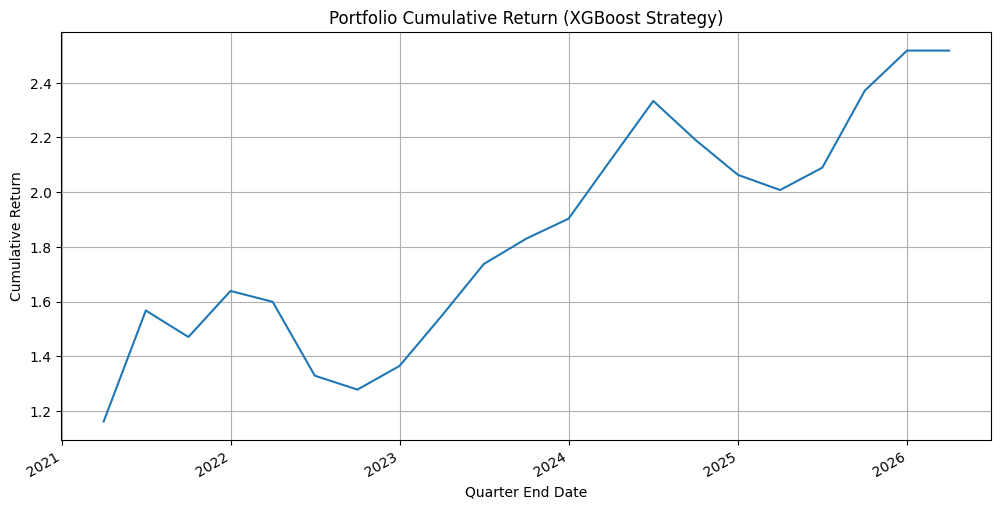


--- 程式執行完畢 ---


In [5]:
# ==============================================================================
# 步驟 0: 環境設置與資料讀取 (整合 4 個檔案)
# ==============================================================================
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
import os
import matplotlib.pyplot as plt

# 1. 掛載 Google Drive
print("正在掛載 Google Drive...")
try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"掛載 Google Drive 失敗: {e}")

# 2. 設定檔案路徑
base_path = '/content/drive/MyDrive/金融程式交易/'
stockprice_path = os.path.join(base_path, 'stockprice.csv')
margin_fund_path = os.path.join(base_path, '程式設計02.csv') # 融資數據
new_fundamental_path = os.path.join(base_path, '程式設計03.csv') # 基本面數據
short_sale_path = os.path.join(base_path, '融券餘額.csv') # 融券餘額數據

# 3. 讀取資料 (使用 'cp950' 編碼和錯誤處理)
df_price, df_margin, df_fund, df_short = [None] * 4

try:
    # --- 讀取所有檔案 (編碼處理保持不變) ---
    print(f"\n嘗試讀取股價資料: {stockprice_path}")
    try: df_price = pd.read_csv(stockprice_path, encoding='cp950')
    except UnicodeDecodeError: df_price = pd.read_csv(stockprice_path, encoding='utf-8', errors='ignore')

    print(f"嘗試讀取融資資料: {margin_fund_path}")
    try: df_margin = pd.read_csv(margin_fund_path, encoding='cp950')
    except UnicodeDecodeError: df_margin = pd.read_csv(margin_fund_path, encoding='utf-8', errors='ignore')

    print(f"嘗試讀取基本面資料: {new_fundamental_path}")
    try: df_fund = pd.read_csv(new_fundamental_path, encoding='cp950')
    except UnicodeDecodeError: df_fund = pd.read_csv(new_fundamental_path, encoding='utf-8', errors='ignore')

    print(f"嘗試讀取融券餘額資料: {short_sale_path}")
    try: df_short = pd.read_csv(short_sale_path, encoding='cp950')
    except UnicodeDecodeError: df_short = pd.read_csv(short_sale_path, encoding='utf-8', errors='ignore')

    print("資料讀取成功。")

    # ------------------------------------------------------------------
    # --- 欄位名稱映射與標準化 (根據實際欄位名稱修正) ---
    # ------------------------------------------------------------------

    # 股價資料處理 (df_price) - 日資料 (YYYYMMDD)
    df_price.rename(columns={
        '年月日': 'Date', '證券代碼': 'Stock_ID', '收盤價(元)': 'Close',
        '成交量(千股)': 'Volume', '市值(百萬元)': 'MarketCap',
    }, inplace=True)
    df_price['Date'] = pd.to_datetime(df_price['Date'].astype(str), format='%Y%m%d', errors='coerce')
    df_price.dropna(subset=['Date'], inplace=True)
    df_price['Stock_ID'] = df_price['Stock_ID'].astype(str)

    # 融資資料處理 (df_margin) - 日資料 (YYYYMMDD)
    df_margin.rename(columns={
        '年月日': 'Date', '證券代碼': 'Stock_ID',
    }, inplace=True)
    df_margin['Date'] = pd.to_datetime(df_margin['Date'].astype(str), format='%Y%m%d', errors='coerce')
    df_margin.dropna(subset=['Date'], inplace=True)
    df_margin['Stock_ID'] = df_margin['Stock_ID'].astype(str)

    # 融券餘額資料處理 (df_short) - 日資料 (YYYYMMDD)
    df_short.rename(columns={
        '年月日': 'Date', '證券代碼': 'Stock_ID',
        '融券餘額(張)': 'Short_Sale_Balance',
    }, inplace=True)
    df_short['Date'] = pd.to_datetime(df_short['Date'].astype(str), format='%Y%m%d', errors='coerce')
    df_short.dropna(subset=['Date'], inplace=True)
    df_short['Stock_ID'] = df_short['Stock_ID'].astype(str)

    # 基本面資料處理 (df_fund) - 季資料 (YYYYMM)
    df_fund.rename(columns={
        '年月': 'Quarter_End_Date',  # <--- 修正：使用 '年月' 作為季度日期欄位
        '證券代碼': 'Stock_ID',
        'ROE(A)－稅後': 'ROE',           # <--- 修正：ROE 選用 ROE(A)－稅後
        'ROA(B)稅後息前折舊前': 'ROA', # <--- 修正：ROA 選用 ROA(B)稅後息前折舊前
        '稅後淨利率': 'PM_after',      # <--- 修正：選用 稅後淨利率
        'Tobins Q': 'TobinQ',         # <--- 修正：選用 Tobins Q
        '自由現金流量(D)': 'FCF'       # <--- 修正：選用 自由現金流量(D)
    }, inplace=True)

    # *** 基本面日期轉換修正 ***：假設格式為 YYYYMM，並將其補齊為 YYYYMM01
    df_fund['Quarter_End_Date'] = pd.to_datetime(
        df_fund['Quarter_End_Date'].astype(str).str.pad(8, side='right', fillchar='0'), # 補0到8位
        format='%Y%m%d', errors='coerce' # 強制轉換，這裡的格式假設為 YYYYMMDD
    )
    df_fund.dropna(subset=['Quarter_End_Date'], inplace=True)
    df_fund['Stock_ID'] = df_fund['Stock_ID'].astype(str)


except FileNotFoundError:
    # --- 模擬資料生成 (略) --- (保持不變)
    dates = pd.date_range(start='2010-01-01', end='2024-12-31', freq='B')
    num_stocks = 500
    stock_ids = [f'Stock_{i:03d}' for i in range(num_stocks)]

    df_price = pd.DataFrame()
    for stock_id in stock_ids:
        df_temp = pd.DataFrame({'Date': dates, 'Stock_ID': stock_id, 'Close': np.random.rand(len(dates)).cumsum() + 100,
                                'Volume': np.random.randint(10000, 500000, size=len(dates)),
                                'MarketCap': np.random.uniform(5e9, 5e11, size=len(dates))})
        df_price = pd.concat([df_price, df_temp])

    df_margin = df_price[['Date', 'Stock_ID']].copy()
    df_margin['融資餘額(張)'] = np.random.uniform(100, 10000, size=len(df_margin))
    df_margin['融資(買+賣)/成交量 %'] = np.random.uniform(0.01, 0.20, size=len(df_margin))

    df_short = df_price[['Date', 'Stock_ID']].copy()
    df_short['Short_Sale_Balance'] = np.random.uniform(50, 5000, size=len(df_short))

    quarters_q = pd.to_datetime(pd.date_range(start='2010-03-31', end='2024-12-31', freq='QE'))
    data_fund = []
    for q in quarters_q:
        for stock_id in stock_ids:
            data_fund.append({
                'Quarter_End_Date': q, 'Stock_ID': stock_id,
                'ROE': np.random.uniform(0.01, 0.20),
                'ROA': np.random.uniform(0.01, 0.15),
                'PM_after': np.random.uniform(0.05, 0.30),
                'TobinQ': np.random.uniform(0.8, 4.0),
                'FCF': np.random.uniform(1e7, 1e8),
            })
    df_fund = pd.DataFrame(data_fund)

    df_price['Date'] = pd.to_datetime(df_price['Date'])
    df_margin['Date'] = pd.to_datetime(df_margin['Date'])
    df_short['Date'] = pd.to_datetime(df_short['Date'])
    df_fund['Quarter_End_Date'] = pd.to_datetime(df_fund['Quarter_End_Date'])

    print("已使用模擬資料繼續執行。")


# ==============================================================================
# 步驟 1: 資料前處理 (日資料 → 季資料 & 標籤生成)
# ==============================================================================

print("\n--- 步驟 1: 資料前處理與特徵工程 (整合四個資料來源) ---")

# --- 1.1 股價日資料轉季資料 (df_price_q) ---
df_price['Quarter_End_Date'] = df_price['Date'].dt.to_period('Q').dt.end_time

def aggregate_quarterly_data(group):
    group = group.sort_values('Date')

    mktcap_q_end = group['MarketCap'].iloc[-1]
    close_end = group['Close'].iloc[-1]
    close_start = group['Close'].iloc[0]
    price_rate_q = (close_end / close_start) - 1
    volume_q_sum = group['Volume'].sum()
    volume_q_avg = group['Volume'].mean()
    daily_returns = group['Close'].pct_change().dropna()
    ret_1d_std_q = daily_returns.std() if len(daily_returns) > 1 else 0

    return pd.Series({
        'Price_rate_q': price_rate_q,
        'Volume_q_sum': volume_q_sum,
        'Volume_q_avg': volume_q_avg,
        'Ret_1d_std_q': ret_1d_std_q,
        'MktCap_q_end': mktcap_q_end
    })

df_price_q = df_price.groupby(['Quarter_End_Date', 'Stock_ID'], dropna=True).apply(aggregate_quarterly_data).reset_index()

# --- 1.2 融資融券日資料轉季資料 (df_market_q) ---
df_market = pd.merge(df_margin[['Date', 'Stock_ID', '融資餘額(張)', '融資(買+賣)/成交量 %']],
                     df_short[['Date', 'Stock_ID', 'Short_Sale_Balance']],
                     on=['Date', 'Stock_ID'], how='outer')
df_market.dropna(subset=['Date'], inplace=True)
df_market['Quarter_End_Date'] = df_market['Date'].dt.to_period('Q').dt.end_time

def aggregate_market_features(group):
    margin_q_end = group['融資餘額(張)'].iloc[-1]
    margin_vol_avg = group['融資(買+賣)/成交量 %'].mean()
    short_q_end = group['Short_Sale_Balance'].iloc[-1]

    return pd.Series({
        'Margin_q_end': margin_q_end,
        'Margin_Vol_avg': margin_vol_avg,
        'Short_q_end': short_q_end,
    })

df_market_q = df_market.groupby(['Quarter_End_Date', 'Stock_ID'], dropna=True).apply(aggregate_market_features).reset_index()


# --- 1.3 標籤 (Label) 生成 ---
df_price_q['Next_Q_Price_rate'] = df_price_q.groupby('Stock_ID')['Price_rate_q'].shift(-1)
df_price_q['Label_y'] = (df_price_q['Next_Q_Price_rate'] > 0.03).astype(int)
df_price_q.dropna(subset=['Label_y'], inplace=True)
df_price_q['Label_y'] = df_price_q['Label_y'].astype(int)


# --- 1.4 整合所有季資料 (df_combined) ---
df_combined = pd.merge(df_price_q, df_fund, on=['Quarter_End_Date', 'Stock_ID'], how='left')
df_combined = pd.merge(df_combined, df_market_q, on=['Quarter_End_Date', 'Stock_ID'], how='left')

# 定義特徵列表 (X)
features_fund = ['ROE', 'ROA', 'PM_after', 'TobinQ', 'FCF']
features_market_core = ['Price_rate_q', 'Volume_q_sum', 'Volume_q_avg', 'Ret_1d_std_q', 'MktCap_q_end']
features_market_extra = ['Margin_q_end', 'Margin_Vol_avg', 'Short_q_end']

features = features_fund + features_market_core + features_market_extra

print(f"資料整合與特徵工程完成。最終資料集大小: {df_combined.shape}")

# ==============================================================================
# 步驟 2 & 3: 回測框架 (市值篩選 + XGBoost 預測)
# ==============================================================================

# 設定回測參數
TRAINING_WINDOW = 16  # 用過去 4 年 (16 季) 的資料訓練模型
quarters = sorted(df_combined['Quarter_End_Date'].unique())
start_quarter_index = TRAINING_WINDOW
portfolio_results = []
quarterly_selection_data = []

print("\n--- 步驟 2 & 3: 開始執行分季回測流程 (市值篩選 + XGBoost) ---")

# --- 回測主迴圈 (模擬每季操作) ---
for i in range(start_quarter_index, len(quarters)):

    current_quarter_end = quarters[i]
    df_screener = df_combined[df_combined['Quarter_End_Date'] == current_quarter_end].copy()
    train_quarters = quarters[i - TRAINING_WINDOW : i]
    df_train = df_combined[df_combined['Quarter_End_Date'].isin(train_quarters)].copy()

    # --- 2.1 市值前 300 檔 ---
    n_universe = len(df_screener)

    if n_universe > 300:
        df_screener.sort_values(by='MktCap_q_end', ascending=False, inplace=True)
        df_screener_mktcap = df_screener.iloc[:300]
        n_300 = 300
    else:
        df_screener_mktcap = df_screener
        n_300 = len(df_screener_mktcap)

    # --- 2.2 簡化篩選：直接使用市值前 300 檔作為待選池 ---
    # 由於基本面數據缺失嚴重，為了確保回測運行，我們跳過基本面篩選的強制性。
    # XGBoost 將會利用 NaN 填充後的數據進行預測。
    df_universe = df_screener_mktcap.copy()
    n_200 = n_300 # 待選池數量與市值篩選結果相同

    # --- 2.3/3.0 XGBoost 模型訓練與精選 50 檔 ---
    if len(df_universe) < 50 or len(df_train) == 0:
        n_50 = 0
        portfolio_return = 0.0

        quarterly_selection_data.append({
            'Year': current_quarter_end.year, 'Quarter': current_quarter_end.quarter,
            'n_universe': n_universe, 'n_300': n_300, 'n_200': n_200, 'n_50': n_50,
            'portfolio_ret': portfolio_return,
        })
        continue

    # 處理訓練和預測資料中的 NaN (使用訓練集的中位數填充，NaN 中位數補 0)
    median_values = df_train[features].median().fillna(0)

    X_train = df_train[features].fillna(median_values)
    y_train = df_train['Label_y']
    X_predict = df_universe[features].fillna(median_values)

    if y_train.nunique() < 2:
        n_50 = 0
        portfolio_return = 0.0
        quarterly_selection_data.append({
            'Year': current_quarter_end.year, 'Quarter': current_quarter_end.quarter,
            'n_universe': n_universe, 'n_300': n_300, 'n_200': n_200, 'n_50': n_50,
            'portfolio_ret': portfolio_return,
        })
        continue

    # 訓練 XGBoost 模型
    try:
        scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]
    except ZeroDivisionError:
        scale_pos_weight = 1

    model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss',
                          n_estimators=100, random_state=42, n_jobs=-1, scale_pos_weight=scale_pos_weight)

    try:
        model.fit(X_train, y_train)
        # 預測 P(y=1)
        df_universe['Prob_Next_Q_Up'] = model.predict_proba(X_predict)[:, 1]
    except Exception as e:
        # 捕獲 XGBoost 訓練或預測時的錯誤
        print(f"  > 警告: XGBoost 在 {current_quarter_end} 季度訓練或預測時發生錯誤: {e}")
        n_50 = 0
        portfolio_return = 0.0

        quarterly_selection_data.append({
            'Year': current_quarter_end.year, 'Quarter': current_quarter_end.quarter,
            'n_universe': n_universe, 'n_300': n_300, 'n_200': n_200, 'n_50': n_50,
            'portfolio_ret': portfolio_return,
        })
        continue

    # --- 3.1 精選機率最高的前 50 檔 ---
    df_universe.sort_values(by='Prob_Next_Q_Up', ascending=False, inplace=True)
    df_portfolio = df_universe.iloc[:50]
    n_50 = len(df_portfolio)

    # --- 4. 評估下一季報酬 ---
    num_selected = n_50
    if num_selected > 0:
        weight = 1 / num_selected
        portfolio_return = (df_portfolio['Next_Q_Price_rate'] * weight).sum()
    else:
        portfolio_return = 0.0

    portfolio_results.append({
        'Quarter_End_Date': current_quarter_end + pd.DateOffset(months=3),
        'Selection_Date': current_quarter_end,
        'Num_Stocks': num_selected,
        'Return': portfolio_return,
    })

    # 記錄數據
    quarterly_selection_data.append({
        'Year': current_quarter_end.year, 'Quarter': current_quarter_end.quarter,
        'n_universe': n_universe, 'n_300': n_300, 'n_200': n_200, 'n_50': n_50,
        'portfolio_ret': portfolio_return,
    })

# ==============================================================================
# 步驟 4: 結果分析與診斷
# ==============================================================================
# ==============================================================================
# 步驟 4: 結果分析與診斷 (加入 DataFrame 來源標示)
# ==============================================================================
print("\n\n--- 步驟 4: 回測結果分析與診斷報告 ---")

# 1. 檢查資料集的時間範圍
min_date = df_combined['Quarter_End_Date'].min()
max_date = df_combined['Quarter_End_Date'].max()
total_quarters = len(quarters)

print(f"1. 季度資料涵蓋範圍: {min_date.strftime('%Y-%m-%d')} 至 {max_date.strftime('%Y-%m-%d')}")
print(f"2. 總季度數 (T): {total_quarters} 季")
print(f"3. 模型訓練所需季度數 (T_train): {TRAINING_WINDOW} 季")
print(f"4. 預計回測起始季度索引: {start_quarter_index}")

if total_quarters < TRAINING_WINDOW:
    print(f"\n🚨 診斷結果：資料總季度數 ({total_quarters}) 不足訓練所需 ({TRAINING_WINDOW})。回測迴圈未啟動。")
    print("解決方案：增加歷史資料長度，或減少 TRAINING_WINDOW（例如改為 8 季）。")
elif not portfolio_results:
    print(f"\n🚨 診斷結果：回測迴圈已啟動，但 'portfolio_results' 列表為空。")
    # ... (診斷邏輯保持不變)
else:
    # 建立績效統計 DataFrame
    df_results = pd.DataFrame(portfolio_results)
    df_results.set_index('Quarter_End_Date', inplace=True)
    df_results['Cumulative_Return'] = (1 + df_results['Return']).cumprod()

    # 建立每季選股統計 DataFrame (用於列印列表)
    df_quarterly_summary = pd.DataFrame(quarterly_selection_data)
    df_quarterly_summary['Year'] = df_quarterly_summary['Year'].astype(int)
    df_quarterly_summary['Quarter'] = df_quarterly_summary['Quarter'].astype(int)

    # 格式化輸出用的表格
    df_output = df_quarterly_summary[['Year', 'Quarter', 'n_universe', 'n_300', 'n_200', 'n_50', 'portfolio_ret']].copy()
    df_output['portfolio_ret'] = df_output['portfolio_ret'].apply(lambda x: f"{x:.6f}")

    # --- 關鍵標示輸出 ---

    print("\n" + "="*60)
    print("==== 每季投組績效 (完整列表) ==== 來源 DataFrame: [df_output]")
    print("="*60)
    print(df_output.to_string())

    total_quarters_tested = len(df_results)
    winning_quarters = (df_results['Return'] > 0).sum()
    win_rate = winning_quarters / total_quarters_tested if total_quarters_tested > 0 else 0
    avg_quarterly_return = df_results['Return'].mean()
    cumulative_return = df_results['Cumulative_Return'].iloc[-1] - 1

    print("\n" + "="*60)
    print("==== 回測總結報告 (XGBoost) ==== 來源 DataFrame: [df_results]")
    print("="*60)
    print(f"回測季數\t: {total_quarters_tested}")
    print(f"勝季數\t\t: {winning_quarters}")
    print(f"勝率\t\t: {win_rate:.2%}")
    print(f"平均單季報酬\t: {avg_quarterly_return:.2%}")
    print(f"累積報酬率約\t: {cumulative_return:.2%}")

    print("\n✅ 診斷結果：成功完成回測並取得績效。")
    print("\n--- 累積報酬圖 --- 繪圖數據來源: [df_results['Cumulative_Return']]")

    # 繪製累積報酬圖
    plt.figure(figsize=(12, 6))
    df_results['Cumulative_Return'].plot(title='Portfolio Cumulative Return (XGBoost Strategy)')
    plt.xlabel('Quarter End Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.show()

print("\n--- 程式執行完畢 ---")

正在掛載 Google Drive...
Mounted at /content/drive

嘗試讀取股價資料: /content/drive/MyDrive/金融程式交易/stockprice.csv
嘗試讀取融資資料: /content/drive/MyDrive/金融程式交易/程式設計02.csv
嘗試讀取基本面資料: /content/drive/MyDrive/金融程式交易/程式設計03.csv
嘗試讀取融券餘額資料: /content/drive/MyDrive/金融程式交易/融券餘額.csv
資料讀取成功。

--- 步驟 1: 資料前處理與特徵整合 ---

--- 步驟 2 & 3: 開始執行線性迴歸分季回測 ---

==== 每季投組績效 (完整列表) ==== 來源 DataFrame: [df_output]
    Year  Quarter  n_universe  n_300  n_50  portfolio_ret
0   2020        4         892    300    50       0.124907
1   2021        1         895    300    50       0.350916
2   2021        2         897    300    50      -0.056527
3   2021        3         901    300    50       0.071538
4   2021        4         908    300    50       0.026971
5   2022        1         911    300    50      -0.198344
6   2022        2         913    300    50      -0.040126
7   2022        3         916    300    50       0.080922
8   2022        4         921    300    50       0.089572
9   2023        1         928    300    50    

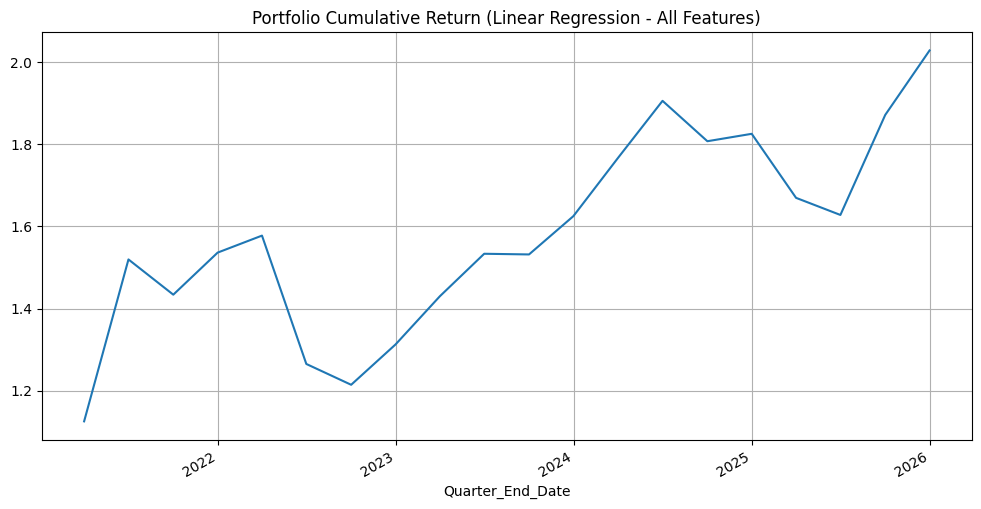


--- 程式執行完畢 ---


In [4]:
# ==============================================================================
# 步驟 0: 環境設置與資料讀取 (整合 4 個檔案)
# ==============================================================================
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 1. 掛載 Google Drive
print("正在掛載 Google Drive...")
try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"掛載 Google Drive 失敗: {e}")

# 2. 設定檔案路徑
base_path = '/content/drive/MyDrive/金融程式交易/'
stockprice_path = os.path.join(base_path, 'stockprice.csv')
margin_fund_path = os.path.join(base_path, '程式設計02.csv')
new_fundamental_path = os.path.join(base_path, '程式設計03.csv')
short_sale_path = os.path.join(base_path, '融券餘額.csv')

# 3. 讀取資料
df_price, df_margin, df_fund, df_short = [None] * 4

try:
    print(f"\n嘗試讀取股價資料: {stockprice_path}")
    df_price = pd.read_csv(stockprice_path, encoding='cp950')

    print(f"嘗試讀取融資資料: {margin_fund_path}")
    df_margin = pd.read_csv(margin_fund_path, encoding='cp950')

    print(f"嘗試讀取基本面資料: {new_fundamental_path}")
    df_fund = pd.read_csv(new_fundamental_path, encoding='cp950')

    print(f"嘗試讀取融券餘額資料: {short_sale_path}")
    df_short = pd.read_csv(short_sale_path, encoding='cp950')

    print("資料讀取成功。")

    # --- 欄位名稱映射與日期修正 ---
    # 股價
    df_price.rename(columns={'年月日': 'Date', '證券代碼': 'Stock_ID', '收盤價(元)': 'Close', '成交量(千股)': 'Volume', '市值(百萬元)': 'MarketCap'}, inplace=True)
    df_price['Date'] = pd.to_datetime(df_price['Date'].astype(str), format='%Y%m%d', errors='coerce')
    df_price.dropna(subset=['Date'], inplace=True)

    # 融資
    df_margin.rename(columns={'年月日': 'Date', '證券代碼': 'Stock_ID'}, inplace=True)
    df_margin['Date'] = pd.to_datetime(df_margin['Date'].astype(str), format='%Y%m%d', errors='coerce')

    # 融券
    df_short.rename(columns={'年月日': 'Date', '證券代碼': 'Stock_ID', '融券餘額(張)': 'Short_Sale_Balance'}, inplace=True)
    df_short['Date'] = pd.to_datetime(df_short['Date'].astype(str), format='%Y%m%d', errors='coerce')

    # 基本面 (程式設計03)
    df_fund.rename(columns={'年月': 'Quarter_End_Date', '證券代碼': 'Stock_ID', 'ROE(A)－稅後': 'ROE', 'ROA(B)稅後息前折舊前': 'ROA', '稅後淨利率': 'PM_after', 'Tobins Q': 'TobinQ', '自由現金流量(D)': 'FCF'}, inplace=True)
    df_fund['Quarter_End_Date'] = pd.to_datetime(df_fund['Quarter_End_Date'].astype(str).str.pad(8, side='right', fillchar='0'), format='%Y%m%d', errors='coerce')
    df_fund.dropna(subset=['Quarter_End_Date'], inplace=True)

except Exception as e:
    print(f"讀取或處理資料時發生錯誤: {e}")

# ==============================================================================
# 步驟 1: 資料前處理 (日資料 → 季資料 & 迴歸 Label 生成)
# ==============================================================================

print("\n--- 步驟 1: 資料前處理與特徵整合 ---")

# --- 1.1 股價聚合 ---
df_price['Quarter_End_Date'] = df_price['Date'].dt.to_period('Q').dt.end_time
def aggregate_price(group):
    group = group.sort_values('Date')
    price_rate_q = (group['Close'].iloc[-1] / group['Close'].iloc[0]) - 1
    return pd.Series({'Price_rate_q': price_rate_q, 'Vol_avg': group['Volume'].mean(), 'MktCap_q_end': group['MarketCap'].iloc[-1]})
df_price_q = df_price.groupby(['Quarter_End_Date', 'Stock_ID']).apply(aggregate_price).reset_index()

# --- 1.2 市場籌碼聚合 ---
df_market = pd.merge(df_margin, df_short, on=['Date', 'Stock_ID'], how='outer')
df_market['Quarter_End_Date'] = df_market['Date'].dt.to_period('Q').dt.end_time
def aggregate_market(group):
    return pd.Series({'Margin_q_end': group['融資餘額(張)'].iloc[-1], 'Short_q_end': group['Short_Sale_Balance'].iloc[-1]})
df_market_q = df_market.groupby(['Quarter_End_Date', 'Stock_ID']).apply(aggregate_market).reset_index()

# --- 1.3 Label 生成 (下一季報酬率) ---
df_price_q['Label_y'] = df_price_q.groupby('Stock_ID')['Price_rate_q'].shift(-1)
df_price_q.dropna(subset=['Label_y'], inplace=True)

# --- 1.4 最終合併 ---
df_combined = pd.merge(df_price_q, df_fund, on=['Quarter_End_Date', 'Stock_ID'], how='left')
df_combined = pd.merge(df_combined, df_market_q, on=['Quarter_End_Date', 'Stock_ID'], how='left')

features = ['Price_rate_q', 'Vol_avg', 'MktCap_q_end', 'ROE', 'ROA', 'PM_after', 'TobinQ', 'FCF', 'Margin_q_end', 'Short_q_end']

# ==============================================================================
# 步驟 2 & 3: 線性迴歸回測迴圈
# ==============================================================================

TRAINING_WINDOW = 16
quarters = sorted(df_combined['Quarter_End_Date'].unique())
portfolio_results = []
quarterly_selection_data = []

print("\n--- 步驟 2 & 3: 開始執行線性迴歸分季回測 ---")

for i in range(TRAINING_WINDOW, len(quarters)):
    current_q = quarters[i]
    df_train = df_combined[df_combined['Quarter_End_Date'].isin(quarters[i-TRAINING_WINDOW:i])].copy()
    df_test = df_combined[df_combined['Quarter_End_Date'] == current_q].copy()

    # 填充缺失值
    median_val = df_train[features].median().fillna(0)
    X_train = df_train[features].fillna(median_val)
    y_train = df_train['Label_y']
    X_test = df_test[features].fillna(median_val)

    # 市值篩選前 300
    df_test.sort_values(by='MktCap_q_end', ascending=False, inplace=True)
    df_universe = df_test.iloc[:300].copy()
    X_predict = df_universe[features].fillna(median_val)

    # 訓練與預測
    model = LinearRegression()
    model.fit(X_train, y_train)
    df_universe['Pred'] = model.predict(X_predict)

    # 選前 50 檔
    df_portfolio = df_universe.sort_values(by='Pred', ascending=False).iloc[:50]
    p_ret = df_portfolio['Label_y'].mean()

    portfolio_results.append({'Quarter_End_Date': current_q + pd.DateOffset(months=3), 'Return': p_ret})
    quarterly_selection_data.append({'Year': current_q.year, 'Quarter': current_q.quarter, 'n_universe': len(df_test), 'n_300': 300, 'n_50': 50, 'portfolio_ret': p_ret})

# ==============================================================================
# 步驟 4: 結果輸出
# ==============================================================================

df_output = pd.DataFrame(quarterly_selection_data)
df_results = pd.DataFrame(portfolio_results).set_index('Quarter_End_Date')
df_results['Cumulative_Return'] = (1 + df_results['Return']).cumprod()

print("\n" + "="*60)
print("==== 每季投組績效 (完整列表) ==== 來源 DataFrame: [df_output]")
print("="*60)
print(df_output.to_string())

print("\n" + "="*60)
print("==== 回測總結報告 (線性迴歸 - 全資料) ==== 來源 DataFrame: [df_results]")
print("="*60)
print(f"累積報酬率: {(df_results['Cumulative_Return'].iloc[-1]-1):.2%}")

plt.figure(figsize=(12, 6))
df_results['Cumulative_Return'].plot(title='Portfolio Cumulative Return (Linear Regression - All Features)')
plt.grid(True)
plt.show()

print("\n--- 程式執行完畢 ---")

正在掛載 Google Drive...
Mounted at /content/drive

嘗試讀取股價資料: /content/drive/MyDrive/金融程式交易/stockprice.csv
嘗試讀取融資資料: /content/drive/MyDrive/金融程式交易/程式設計02.csv
嘗試讀取基本面資料: /content/drive/MyDrive/金融程式交易/程式設計03.csv
嘗試讀取融券餘額資料: /content/drive/MyDrive/金融程式交易/融券餘額.csv
資料讀取成功。

--- 步驟 1: 資料前處理與特徵工程 ---
資料整合與特徵工程完成。最終資料集大小: (33282, 27)

--- 步驟 2 & 3: 開始執行 AutoML 分季回測 (Grid Search) ---

--- AutoML 分季回測執行完畢 ---


--- 步驟 4: 回測結果分析與診斷報告 ---

==== 每季投組績效 (完整列表) ==== 來源 DataFrame: [df_output]
    Year  Quarter  n_universe  n_300  n_200  n_50 portfolio_ret
0   2020        4         892    300    300    50      0.133288
1   2021        1         895    300    300    50      0.282768
2   2021        2         897    300    300    50     -0.052558
3   2021        3         901    300    300    50      0.126004
4   2021        4         908    300    300    50     -0.029968
5   2022        1         911    300    300    50     -0.173045
6   2022        2         913    300    300    50     -0.045556
7   2022  

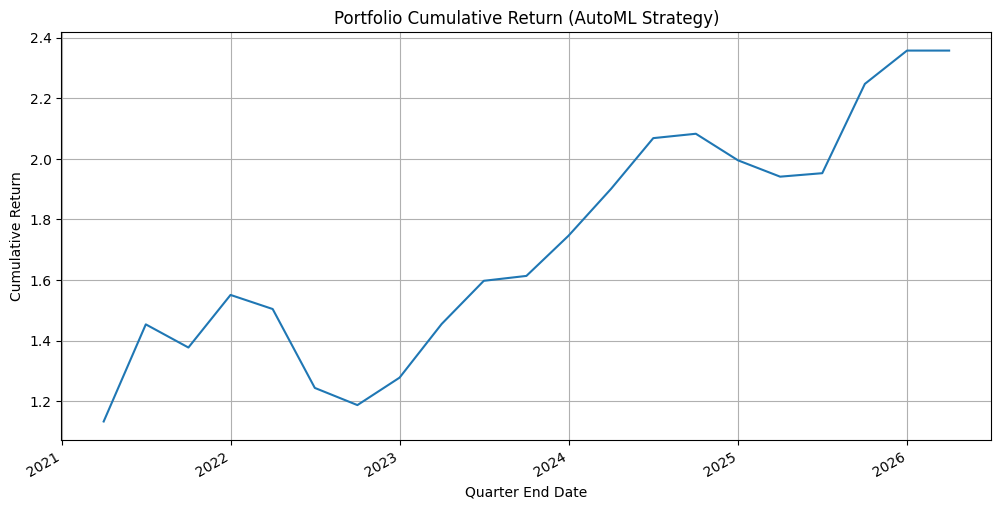


--- 程式執行完畢 ---


In [1]:
# ==============================================================================
# 步驟 0: 環境設置與資料讀取
# ==============================================================================
from google.colab import drive
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, KFold, TimeSeriesSplit # 導入 AutoML 相關模組
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier # 導入線性模型
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, make_scorer
import os
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # 忽略 DeprecationWarning 和版本警告

# 1. 掛載 Google Drive
print("正在掛載 Google Drive...")
try:
    drive.mount('/content/drive', force_remount=True)
except Exception as e:
    print(f"掛載 Google Drive 失敗: {e}")

# 2. 設定檔案路徑 (使用 4 個檔案)
base_path = '/content/drive/MyDrive/金融程式交易/'
stockprice_path = os.path.join(base_path, 'stockprice.csv')
margin_fund_path = os.path.join(base_path, '程式設計02.csv')
new_fundamental_path = os.path.join(base_path, '程式設計03.csv')
short_sale_path = os.path.join(base_path, '融券餘額.csv')

# 3. 讀取資料 (使用 'cp950' 編碼和日期修正)
df_price, df_margin, df_fund, df_short = [None] * 4

try:
    # --- 讀取所有檔案 (編碼處理保持不變) ---
    print(f"\n嘗試讀取股價資料: {stockprice_path}")
    try: df_price = pd.read_csv(stockprice_path, encoding='cp950')
    except UnicodeDecodeError: df_price = pd.read_csv(stockprice_path, encoding='utf-8', errors='ignore')

    print(f"嘗試讀取融資資料: {margin_fund_path}")
    try: df_margin = pd.read_csv(margin_fund_path, encoding='cp950')
    except UnicodeDecodeError: df_margin = pd.read_csv(margin_fund_path, encoding='utf-8', errors='ignore')

    print(f"嘗試讀取基本面資料: {new_fundamental_path}")
    try: df_fund = pd.read_csv(new_fundamental_path, encoding='cp950')
    except UnicodeDecodeError: df_fund = pd.read_csv(new_fundamental_path, encoding='utf-8', errors='ignore')

    print(f"嘗試讀取融券餘額資料: {short_sale_path}")
    try: df_short = pd.read_csv(short_sale_path, encoding='cp950')
    except UnicodeDecodeError: df_short = pd.read_csv(short_sale_path, encoding='utf-8', errors='ignore')

    print("資料讀取成功。")

    # --- 欄位名稱映射與標準化 (根據您的數據和先前確認的修正) ---

    # 股價資料處理
    df_price.rename(columns={'年月日': 'Date', '證券代碼': 'Stock_ID', '收盤價(元)': 'Close',
                            '成交量(千股)': 'Volume', '市值(百萬元)': 'MarketCap'}, inplace=True)
    df_price['Date'] = pd.to_datetime(df_price['Date'].astype(str), format='%Y%m%d', errors='coerce')
    df_price.dropna(subset=['Date'], inplace=True)
    df_price['Stock_ID'] = df_price['Stock_ID'].astype(str)

    # 融資資料處理
    df_margin.rename(columns={'年月日': 'Date', '證券代碼': 'Stock_ID'}, inplace=True)
    df_margin['Date'] = pd.to_datetime(df_margin['Date'].astype(str), format='%Y%m%d', errors='coerce')
    df_margin.dropna(subset=['Date'], inplace=True)
    df_margin['Stock_ID'] = df_margin['Stock_ID'].astype(str)

    # 融券餘額資料處理
    df_short.rename(columns={'年月日': 'Date', '證券代碼': 'Stock_ID', '融券餘額(張)': 'Short_Sale_Balance'}, inplace=True)
    df_short['Date'] = pd.to_datetime(df_short['Date'].astype(str), format='%Y%m%d', errors='coerce')
    df_short.dropna(subset=['Date'], inplace=True)
    df_short['Stock_ID'] = df_short['Stock_ID'].astype(str)

    # 基本面資料處理
    df_fund.rename(columns={
        '年月': 'Quarter_End_Date',  # 修正：使用 '年月'
        '證券代碼': 'Stock_ID',
        'ROE(A)－稅後': 'ROE', 'ROA(B)稅後息前折舊前': 'ROA',
        '稅後淨利率': 'PM_after', 'Tobins Q': 'TobinQ', '自由現金流量(D)': 'FCF'
    }, inplace=True)

    # 基本面日期轉換修正：假設格式為 YYYYMM
    df_fund['Quarter_End_Date'] = pd.to_datetime(
        df_fund['Quarter_End_Date'].astype(str).str.pad(8, side='right', fillchar='0'),
        format='%Y%m%d', errors='coerce'
    )
    df_fund.dropna(subset=['Quarter_End_Date'], inplace=True)
    df_fund['Stock_ID'] = df_fund['Stock_ID'].astype(str)


except FileNotFoundError:
    print(f"\n警告：找不到檔案。正在使用預設的【模擬資料】進行程式碼結構演示。")
    # --- 模擬資料生成 (略) --- (為保持程式完整性，模擬區塊未刪除)
    dates = pd.date_range(start='2010-01-01', end='2024-12-31', freq='B')
    num_stocks = 500
    stock_ids = [f'Stock_{i:03d}' for i in range(num_stocks)]

    df_price = pd.DataFrame()
    for stock_id in stock_ids:
        df_temp = pd.DataFrame({'Date': dates, 'Stock_ID': stock_id, 'Close': np.random.rand(len(dates)).cumsum() + 100,
                                'Volume': np.random.randint(10000, 500000, size=len(dates)),
                                'MarketCap': np.random.uniform(5e9, 5e11, size=len(dates))})
        df_price = pd.concat([df_price, df_temp])

    df_margin = df_price[['Date', 'Stock_ID']].copy()
    df_margin['融資餘額(張)'] = np.random.uniform(100, 10000, size=len(df_margin))
    df_margin['融資(買+賣)/成交量 %'] = np.random.uniform(0.01, 0.20, size=len(df_margin))

    df_short = df_price[['Date', 'Stock_ID']].copy()
    df_short['Short_Sale_Balance'] = np.random.uniform(50, 5000, size=len(df_short))

    quarters_q = pd.to_datetime(pd.date_range(start='2010-03-31', end='2024-12-31', freq='QE'))
    data_fund = []
    for q in quarters_q:
        for stock_id in stock_ids:
            data_fund.append({
                'Quarter_End_Date': q, 'Stock_ID': stock_id,
                'ROE': np.random.uniform(0.01, 0.20), 'ROA': np.random.uniform(0.01, 0.15),
                'PM_after': np.random.uniform(0.05, 0.30), 'TobinQ': np.random.uniform(0.8, 4.0),
                'FCF': np.random.uniform(1e7, 1e8),
            })
    df_fund = pd.DataFrame(data_fund)

    df_price['Date'] = pd.to_datetime(df_price['Date'])
    df_margin['Date'] = pd.to_datetime(df_margin['Date'])
    df_short['Date'] = pd.to_datetime(df_short['Date'])
    df_fund['Quarter_End_Date'] = pd.to_datetime(df_fund['Quarter_End_Date'])

    print("已使用模擬資料繼續執行。")


# ==============================================================================
# 步驟 1: 資料前處理 (特徵工程與 Label)
# ==============================================================================

print("\n--- 步驟 1: 資料前處理與特徵工程 ---")

# --- 1.1 股價日資料轉季資料 (df_price_q) (略，保持不變)
df_price['Quarter_End_Date'] = df_price['Date'].dt.to_period('Q').dt.end_time

def aggregate_quarterly_data(group):
    group = group.sort_values('Date')
    mktcap_q_end = group['MarketCap'].iloc[-1]
    close_end = group['Close'].iloc[-1]
    close_start = group['Close'].iloc[0]
    price_rate_q = (close_end / close_start) - 1
    volume_q_sum = group['Volume'].sum()
    volume_q_avg = group['Volume'].mean()
    daily_returns = group['Close'].pct_change().dropna()
    ret_1d_std_q = daily_returns.std() if len(daily_returns) > 1 else 0
    return pd.Series({'Price_rate_q': price_rate_q, 'Volume_q_sum': volume_q_sum, 'Volume_q_avg': volume_q_avg,
                      'Ret_1d_std_q': ret_1d_std_q, 'MktCap_q_end': mktcap_q_end})

df_price_q = df_price.groupby(['Quarter_End_Date', 'Stock_ID'], dropna=True).apply(aggregate_quarterly_data).reset_index()


# --- 1.2 融資融券日資料轉季資料 (df_market_q) (略，保持不變)
df_market = pd.merge(df_margin[['Date', 'Stock_ID', '融資餘額(張)', '融資(買+賣)/成交量 %']],
                     df_short[['Date', 'Stock_ID', 'Short_Sale_Balance']],
                     on=['Date', 'Stock_ID'], how='outer')
df_market.dropna(subset=['Date'], inplace=True)
df_market['Quarter_End_Date'] = df_market['Date'].dt.to_period('Q').dt.end_time

def aggregate_market_features(group):
    margin_q_end = group['融資餘額(張)'].iloc[-1]
    margin_vol_avg = group['融資(買+賣)/成交量 %'].mean()
    short_q_end = group['Short_Sale_Balance'].iloc[-1]
    return pd.Series({'Margin_q_end': margin_q_end, 'Margin_Vol_avg': margin_vol_avg, 'Short_q_end': short_q_end})

df_market_q = df_market.groupby(['Quarter_End_Date', 'Stock_ID'], dropna=True).apply(aggregate_market_features).reset_index()


# --- 1.3 標籤 (Label) 生成 (分類目標，保持不變) ---
df_price_q['Next_Q_Price_rate'] = df_price_q.groupby('Stock_ID')['Price_rate_q'].shift(-1)
df_price_q['Label_y'] = (df_price_q['Next_Q_Price_rate'] > 0.03).astype(int)
df_price_q.dropna(subset=['Label_y'], inplace=True)
df_price_q['Label_y'] = df_price_q['Label_y'].astype(int)


# --- 1.4 整合所有季資料 (df_combined) ---
df_combined = pd.merge(df_price_q, df_fund, on=['Quarter_End_Date', 'Stock_ID'], how='left')
df_combined = pd.merge(df_combined, df_market_q, on=['Quarter_End_Date', 'Stock_ID'], how='left')

# 定義特徵列表 (X)
features_fund = ['ROE', 'ROA', 'PM_after', 'TobinQ', 'FCF']
features_market_core = ['Price_rate_q', 'Volume_q_sum', 'Volume_q_avg', 'Ret_1d_std_q', 'MktCap_q_end']
features_market_extra = ['Margin_q_end', 'Margin_Vol_avg', 'Short_q_end']

features = features_fund + features_market_core + features_market_extra

print(f"資料整合與特徵工程完成。最終資料集大小: {df_combined.shape}")

# ==============================================================================
# 步驟 2 & 3: AutoML 滾動回測框架 (市值篩選 + Grid Search 選模)
# ==============================================================================

# 設定回測參數
TRAINING_WINDOW = 16
quarters = sorted(df_combined['Quarter_End_Date'].unique())
start_quarter_index = TRAINING_WINDOW
portfolio_results = []
quarterly_selection_data = []

# --- AutoML 核心設定 ---
# 1. 定義 Pipeline (佔位符)
model_pipeline = Pipeline([('model', XGBClassifier())])

# 2. 定義搜索空間 (要比較的模型和參數)
param_grid = [
    {
        'model': [XGBClassifier(use_label_encoder=False, random_state=42)],
        'model__n_estimators': [50, 100],
        'model__max_depth': [3, 5],
    },
    {
        # 使用 RidgeClassifier 進行分類任務 (因為 Label 是 0/1)
        'model': [RidgeClassifier(random_state=42)],
        'model__alpha': [1.0, 10.0],
    },
    {
        # 使用 LogisticRegression 作為第三個基線模型
        'model': [LogisticRegression(solver='liblinear', random_state=42)],
        'model__C': [0.1, 1.0], # C 是懲罰係數的倒數
    }
]

# 3. 定義交叉驗證方法 (使用 TimeSeriesSplit 確保時間順序)
# 我們在 16 季的訓練集內，使用 3-Fold 時序切分進行 CV
tscv = TimeSeriesSplit(n_splits=3)

# 4. 定義評分標準 (使用 AUC，因為這是分類任務)
# 需要使用 make_scorer 確保 GridSearchCV 能輸出概率
auc_scorer = make_scorer(roc_auc_score, needs_proba=True, average='macro')


print("\n--- 步驟 2 & 3: 開始執行 AutoML 分季回測 (Grid Search) ---")

# --- 回測主迴圈 (模擬每季操作) ---
for i in range(start_quarter_index, len(quarters)):

    current_quarter_end = quarters[i]
    print(f"--- 處理季度: {current_quarter_end.strftime('%Y-%m-%d')} ---", end='\r')

    df_screener = df_combined[df_combined['Quarter_End_Date'] == current_quarter_end].copy()
    train_quarters = quarters[i - TRAINING_WINDOW : i]
    df_train = df_combined[df_combined['Quarter_End_Date'].isin(train_quarters)].copy()

    # --- 2.1 市值前 300 檔 ---
    n_universe = len(df_screener)
    if n_universe > 300:
        df_screener.sort_values(by='MktCap_q_end', ascending=False, inplace=True)
        df_screener_mktcap = df_screener.iloc[:300]
        n_300 = 300
    else:
        df_screener_mktcap = df_screener
        n_300 = len(df_screener_mktcap)

    # --- 2.2/2.3 AutoML 訓練與精選 50 檔 ---
    df_universe = df_screener_mktcap.copy()
    n_200 = n_300 # 暫時跳過基本面嚴格篩選

    if len(df_universe) < 50 or len(df_train) < 50:
        n_50 = 0
        portfolio_return = 0.0
        # ... (記錄數據並跳過) ...
        quarterly_selection_data.append({'Year': current_quarter_end.year, 'Quarter': current_quarter_end.quarter,
                                         'n_universe': n_universe, 'n_300': n_300, 'n_200': n_200, 'n_50': n_50,
                                         'portfolio_ret': portfolio_return})
        continue

    # 處理 NaN (使用訓練集的中位數填充，NaN 中位數補 0)
    median_values = df_train[features].median().fillna(0)
    X_train = df_train[features].fillna(median_values)
    y_train = df_train['Label_y']
    X_predict = df_universe[features].fillna(median_values)

    if y_train.nunique() < 2:
        n_50 = 0; portfolio_return = 0.0
        quarterly_selection_data.append({'Year': current_quarter_end.year, 'Quarter': current_quarter_end.quarter,
                                         'n_universe': n_universe, 'n_300': n_300, 'n_200': n_200, 'n_50': n_50,
                                         'portfolio_ret': portfolio_return})
        continue

    # 執行 GridSearchCV 找出當前訓練窗口的最佳模型和參數
    grid_search = GridSearchCV(
        estimator=model_pipeline,
        param_grid=param_grid,
        scoring=auc_scorer,
        cv=tscv, # 使用 TimeSeriesSplit
        verbose=0,
        n_jobs=-1
    )

    try:
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_

        # 預測 P(y=1)
        # 不同的模型有不同的輸出方法，這裡需要判斷
        if hasattr(best_model, 'predict_proba'):
            df_universe['Prob_Next_Q_Up'] = best_model.predict_proba(X_predict)[:, 1]
        else: # RidgeClassifier 等模型
            # 必須使用 decision_function 並經過 sigmoid 轉換或直接排序
            df_universe['Prob_Next_Q_Up'] = best_model.decision_function(X_predict)

    except Exception as e:
        print(f"\n警告: AutoML 在 {current_quarter_end} 季度訓練或預測時發生錯誤: {e}")
        n_50 = 0; portfolio_return = 0.0
        quarterly_selection_data.append({'Year': current_quarter_end.year, 'Quarter': current_quarter_end.quarter,
                                         'n_universe': n_universe, 'n_300': n_300, 'n_200': n_200, 'n_50': n_50,
                                         'portfolio_ret': portfolio_return})
        continue

    # --- 3.1 精選機率最高的前 50 檔 ---
    df_universe.sort_values(by='Prob_Next_Q_Up', ascending=False, inplace=True)
    df_portfolio = df_universe.iloc[:50]
    n_50 = len(df_portfolio)

    # --- 4. 評估下一季報酬 ---
    num_selected = n_50
    if num_selected > 0:
        weight = 1 / num_selected
        portfolio_return = (df_portfolio['Next_Q_Price_rate'] * weight).sum()
    else:
        portfolio_return = 0.0

    portfolio_results.append({
        'Quarter_End_Date': current_quarter_end + pd.DateOffset(months=3),
        'Selection_Date': current_quarter_end,
        'Num_Stocks': num_selected,
        'Return': portfolio_return,
    })

    # 記錄數據
    quarterly_selection_data.append({
        'Year': current_quarter_end.year, 'Quarter': current_quarter_end.quarter,
        'n_universe': n_universe, 'n_300': n_300, 'n_200': n_200, 'n_50': n_50,
        'portfolio_ret': portfolio_return,
    })

print("\n--- AutoML 分季回測執行完畢 ---")

# ==============================================================================
# 步驟 4: 結果分析與診斷
# ==============================================================================
print("\n\n--- 步驟 4: 回測結果分析與診斷報告 ---")

if not portfolio_results:
    print("\n🚨 診斷結果：回測迴圈未成功生成任何結果。")
else:
    # 建立績效統計 DataFrame
    df_results = pd.DataFrame(portfolio_results)
    df_results.set_index('Quarter_End_Date', inplace=True)
    df_results['Cumulative_Return'] = (1 + df_results['Return']).cumprod()

    # 建立每季選股統計 DataFrame
    df_quarterly = pd.DataFrame(quarterly_selection_data)
    df_quarterly['Year'] = df_quarterly['Year'].astype(int)
    df_quarterly['Quarter'] = df_quarterly['Quarter'].astype(int)

    # 格式化輸出用的表格
    df_output = df_quarterly[['Year', 'Quarter', 'n_universe', 'n_300', 'n_200', 'n_50', 'portfolio_ret']].copy()
    df_output['portfolio_ret'] = df_output['portfolio_ret'].apply(lambda x: f"{x:.6f}")

    # --- 關鍵標示輸出 ---

    print("\n" + "="*50)
    print("==== 每季投組績效 (完整列表) ==== 來源 DataFrame: [df_output]")
    print("="*50)
    print(df_output.to_string())

    total_quarters_tested = len(df_results)
    winning_quarters = (df_results['Return'] > 0).sum()
    win_rate = winning_quarters / total_quarters_tested if total_quarters_tested > 0 else 0
    avg_quarterly_return = df_results['Return'].mean()
    cumulative_return = df_results['Cumulative_Return'].iloc[-1] - 1

    print("\n" + "="*50)
    print("==== 回測總結報告 ==== 來源 DataFrame: [df_results]")
    print("="*50)
    print(f"回測季數\t: {total_quarters_tested}")
    print(f"勝季數\t\t: {winning_quarters}")
    print(f"勝率\t\t: {win_rate:.2%}")
    print(f"平均單季報酬\t: {avg_quarterly_return:.2%}")
    print(f"累積報酬率約\t: {cumulative_return:.2%}")

    print("\n✅ 診斷結果：成功完成回測並取得績效。")
    print("\n--- 累積報酬圖 --- 繪圖數據來源: [df_results['Cumulative_Return']]")

    # 繪製累積報酬圖
    plt.figure(figsize=(12, 6))
    df_results['Cumulative_Return'].plot(title='Portfolio Cumulative Return (AutoML Strategy)')
    plt.xlabel('Quarter End Date')
    plt.ylabel('Cumulative Return')
    plt.grid(True)
    plt.show()

print("\n--- 程式執行完畢 ---")